In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, hour, avg
import matplotlib.pyplot as plt

# 1. 환경 설정 및 데이터 로딩
spark = SparkSession.builder \
    .appName("NYC TLC Trip Record Analysis") \
    .getOrCreate()

# Parquet 또는 CSV 파일 로딩
# 아래에서 "parquet" 또는 "csv" 파일 형식에 맞게 파일 경로를 조정합니다.
df = spark.read.parquet("/mnt/data/fhv_tripdata_2022-07.parquet")
# 또는 CSV 파일인 경우
# df = spark.read.csv("/mnt/data/fhv_tripdata_2022-07.csv", header=True, inferSchema=True)

# 데이터 구조 확인
df.printSchema()
df.show(5)

root
 |-- dispatching_base_num: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropOff_datetime: timestamp (nullable = true)
 |-- PUlocationID: double (nullable = true)
 |-- DOlocationID: double (nullable = true)
 |-- SR_Flag: integer (nullable = true)
 |-- Affiliated_base_number: string (nullable = true)



In [ ]:
# 2. 데이터 정리 및 변환
# 날짜와 시간을 표준 타임스탬프로 변환
df = df.withColumn("pickup_datetime", col("pickup_datetime").cast("timestamp"))
df = df.withColumn("dropoff_datetime", col("dropoff_datetime").cast("timestamp"))

# 여행 시간(초) 계산
df = df.withColumn("trip_duration_seconds", unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime"))

# 음수 거리 또는 시간이 있는 레코드 필터링
df = df.filter(col("trip_duration_seconds") > 0)

# 정리된 데이터 확인
df.show(5)


+--------------------+-------------------+-------------------+------------+------------+-------+----------------------+
|dispatching_base_num|    pickup_datetime|   dropOff_datetime|PUlocationID|DOlocationID|SR_Flag|Affiliated_base_number|
+--------------------+-------------------+-------------------+------------+------------+-------+----------------------+
|              B00037|2022-07-01 00:11:50|2022-07-01 00:24:04|        null|        39.0|   null|                B00037|
|              B00037|2022-07-01 00:49:45|2022-07-01 00:57:04|        null|        89.0|   null|                B00037|
|              B00111|2022-07-01 00:06:22|2022-07-01 01:26:00|        null|        null|   null|                B00111|
|              B00112|2022-07-01 00:05:40|2022-07-01 00:18:33|        null|        22.0|   null|                B00112|
|              B00112|2022-07-01 00:49:48|2022-07-01 01:01:53|        null|        67.0|   null|                B00112|
+--------------------+------------------

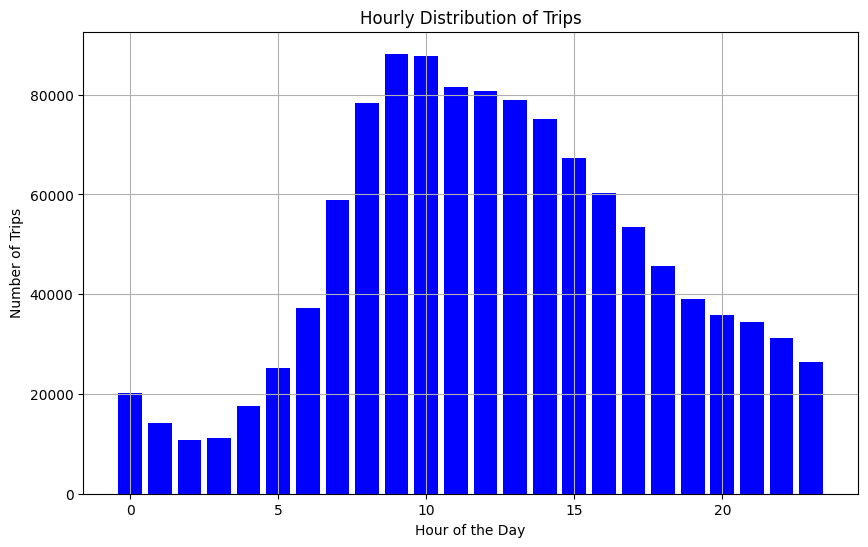

AnalysisException: path file:/mnt/data/cleaned_fhv_tripdata_2022-07.parquet already exists.

In [ ]:

# 3. 메트릭 계산
# 평균 여행 시간 계산
average_trip_duration = df.select(avg("trip_duration_seconds")).first()[0]
print(f"Average Trip Duration: {average_trip_duration} seconds")

# 평균 여행 거리 계산 (예: trip_distance 컬럼이 있다고 가정)
# average_trip_distance = df.select(avg("trip_distance")).first()[0]
# print(f"Average Trip Distance: {average_trip_distance} miles")

In [ ]:

# 4. 피크 시간 분석
df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))
hourly_trips = df.groupBy("pickup_hour").count().orderBy("pickup_hour")

# 시간대별 여행 수 시각화
hourly_trips_pd = hourly_trips.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(hourly_trips_pd["pickup_hour"], hourly_trips_pd["count"], color='blue')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.title("Hourly Distribution of Trips")
plt.grid(True)
plt.show()


In [ ]:

# 5. 날씨 상태 분석 (필요한 경우 외부 날씨 데이터를 로드하고 분석)
# 날씨 데이터와 결합하여 분석할 수 있습니다.
# weather_df = spark.read.csv("/path_to_weather_data.csv", header=True, inferSchema=True)
# weather_analysis_df = df.join(weather_df, "date_column")

# 6. 결과 저장 및 추가 시각화
# 데이터 저장
df.write.parquet("/mnt/data/cleaned_fhv_tripdata_2022-07.parquet")

# 추가 분석 결과를 저장하거나 시각화할 수 있습니다.